# analyze GPA

## exploding losses
In many cases, including the standard settings, the model is not able to train. After only a few epochs, the losses explode.

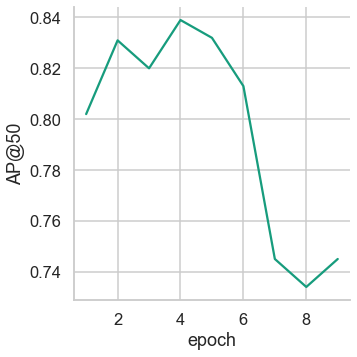

In [2]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'std']]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['i', 'mode'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=40], x='occurrence', y='value', kind='line')
g.set_axis_labels('epoch', 'AP@50')

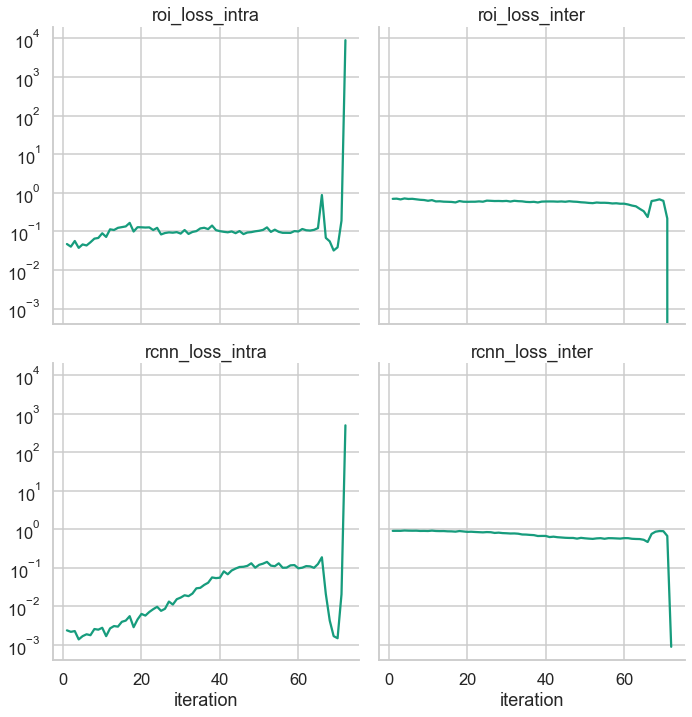

In [7]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'std']]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['i', 'mode'], ['roi_loss_intra', 'roi_loss_inter', 'rcnn_loss_intra', 'rcnn_loss_inter'], logs, get_max=True)

g = sb.relplot(data=df, x='occurrence', y='value', kind='line', col='metric', height=5, aspect=1., col_wrap=2)
g.set_axis_labels('iteration', '')
g.set_titles(col_template='{col_name}', row_template='')
plt.yscale('log')

## automatic loss-balancing
We suspect the problem is due to poorly-balanced losses and first try a method for automatic loss-balancing. With simple initialization the method is not able to outperform manual balancing or even the fine-tuning baseline.

Looking at the resulting magnitudes, one problem might be the greedy over-emphasis of the RCNN inter-class loss that, when optimized alone, can increase the performance by helping classification in the head.

As a counter-measure, we try using auto-balancing on top of the manual optimum.

[{'bbox_mAP_50': (25.0, 0.85)}, {'bbox_mAP_50': (56.0, 0.847)}, {'bbox_mAP_50': (4.0, 0.849)}, {'bbox_mAP_50': (6.0, 0.842)}]


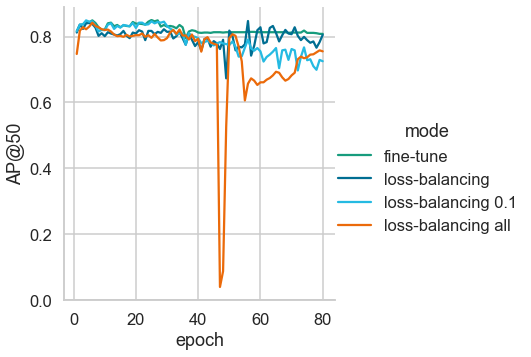

In [7]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_ft_80_step40_seeded.log', 'fine-tune'],
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_auto.log', 'loss-balancing'],
        ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_auto.log', 'loss-balancing 0.1'],
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_autoall.log', 'loss-balancing all']]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['mode'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=80], x='occurrence', y='value', kind='line', hue='mode')
g.set_axis_labels('epoch', 'AP@50')
print(maxs)

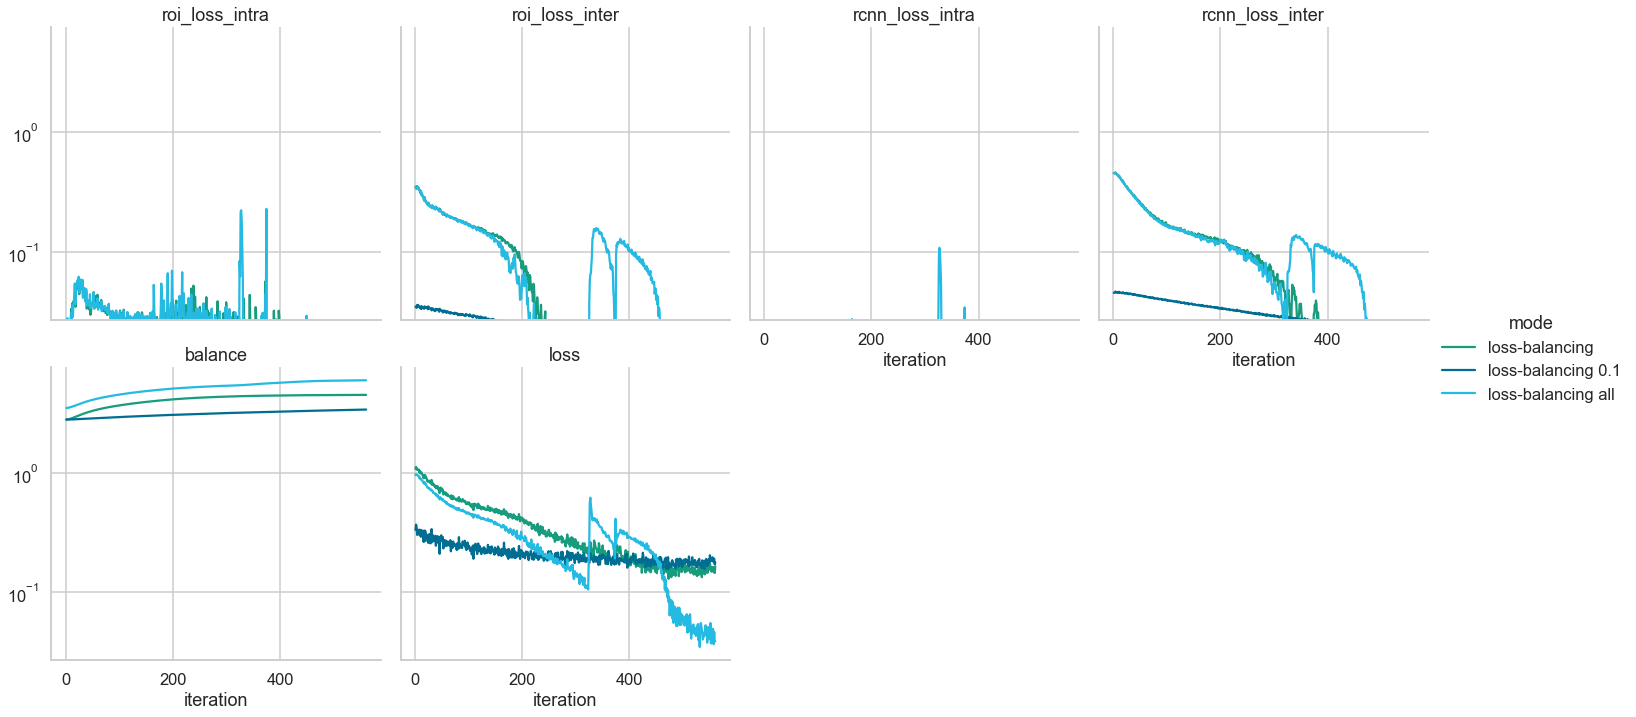

In [8]:
from log_analysis import *

logs = [['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_auto.log', 'loss-balancing'],
        ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_auto.log', 'loss-balancing 0.1'],
        ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_autoall.log', 'loss-balancing all']]

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['mode'], ['roi_loss_intra', 'roi_loss_inter', 'rcnn_loss_intra', 'rcnn_loss_inter', 'balance', 'loss'], logs, get_max=True)

g = sb.relplot(data=df, x='occurrence', y='value', kind='line', hue='mode', col='metric', height=5, aspect=1., col_wrap=4)
g.set_axis_labels('iteration', '')
g.set_titles(col_template='{col_name}', row_template='')
plt.yscale('log')

In [1]:
from log_analysis import *

log = 'GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_autoall.log'

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

weight_dict = keys_from_log(log, ['w old', 'w ROI intra', 'w ROI inter', 'w RCNN intra', 'w RCNN inter'])

print([weight_dict[k][-1] for k in weight_dict.keys()])

# g = sb.relplot(data=df, x='occurrence', y='value', kind='line', hue='mode', col='metric', height=5, aspect=1., col_wrap=4)
# g.set_axis_labels('iteration', '')
# g.set_titles(col_template='{col_name}', row_template='')
# plt.yscale('log')

[0.2121153473854065, 0.3209385871887207, 0.16771206259727478, 0.39049798250198364, 0.1356126219034195, 4464]


## manual loss-balancing
Then we manually find the optimum.

[{'bbox_mAP_50': (25.0, 0.85)}, {'bbox_mAP_50': (25.0, 0.871)}, {'bbox_mAP_50': (25.0, 0.882)}]


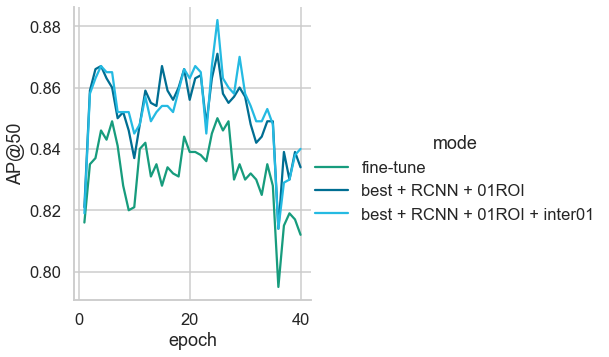

In [10]:
# which adaptations improve performance on (seeded) split 100a?
# -> euclidean might work best
# -> both losses can be decreased individually, but currently not together
# -> da=1 might be too high, losses explode
# -> higher intra vs inter helps, but not unlimited
logs = [
        ['GPA/tuning/coco_piropo_100a_ft_80_step40_seeded.log', 'a', '0', 'fine-tune'],                                # baseline
        # ['GPA/tuning/coco_piropo_100a_da01roi0rcnn1intra1inter0cosine_seed.log', 'a', '0', '"best"'],                  # previous best experiment
        # ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'GPA × 0.1'],# -> can't decrease intra-losses
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtTruemean_squared_seed.log', 'a', '0', 'gt'],     # -> roi intra-loss explode
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nTruegtFalsemean_squared_seed.log', 'a', '0', 'norm'],   # -> roi intra-loss explode
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalseeuclidean_seed.log', 'a', '0', 'eucl'],     # -> might have worked with more epochs, most "well-behaved" loss, all losses decrease
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter1nFalsegtFalsecosine_seed.log', 'a', '0', 'cosine'],      # -> no improvement, but all losses decrease
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra1inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'ROI'],   # -> unstable, but eventual improvement, might have worked with more epochs
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra1inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'RCNN'],  # -> no improvement, losses explode
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra0inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'only inter'], # -> 0.875!
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra1inter0nFalsegtFalsemean_squared_seed.log', 'a', '0', 'GPA only intra-loss'], # -> 0.856
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn10intra1inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'RCNN10'],# -> explode
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn100intra1inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'RCNN100'],# -> explode
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1000intra1inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'RCNN1000'],# -> explode
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra10inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'RCNN intra 10'],# -> 0.846
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed0.log', 'a', '0', 'GPA intra-loss × 100'],# -> 0.863!
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra1000inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'RCNN intra 1000'],# -> 0.857
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra10inter0nFalsegtFalsemean_squared_seed.log', 'a', '0', 'RCNN intra 10 inter 0'],# -> 0.855
        # ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra1inter1nFalsegtFalsemean_squared_seed_trainsrc.log', 'a', '0', 'GPA0.1 + src'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da01roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed_trainsrc.log', 'a', '0', 'GPA0.1 + intra100 + src'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seedapool.log', 'a', '0', 'RCNNinter100 avgpool'], # no improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seedmpool.log', 'a', '0', 'RCNNinter100 maxpool'], # takes long to learn anything
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed_nofc.log', 'a', '0', 'RCNNinter100 nofc'], # 0.869!
        # ['GPA/tuning/coco_piropo_100a_da01roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best x 0.1'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da10roi0rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best x 10'],# doesn't train
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best + ROI'],# deteriorates
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn01intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best + 01RCNN + ROI'],# much worse
        ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best + RCNN + 01ROI'],# -> 0.871!
        # ['GPA/tuning/coco_piropo_100a_da01roi1rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best + 01RCNN + 01ROI'],# -> 0.867!
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best ROI'],# worse
        # ['GPA/tuning/coco_piropo_100a_da01roi1rcnn0intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best ROI x 01'],# slight improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra10inter01nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best ROI intra 10 inter 01'],# 0.869!
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra1inter001nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best ROI intra 1 inter 001'],# slight improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalseeuclidean_seed.log', 'a', '0', 'best euclidean'],# doesn't train
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra100inter1nFalsegtFalsecosine_seed.log', 'a', '0', 'best cosine'],# some training problem
        # ['GPA/tuning/coco_piropo_100a_da01roi0rcnn1intra100inter1nTruegtFalsemean_squared_seed.log', 'a', '0', 'best normalized'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da01roi0rcnn1intra100inter1nFalsegtTruemean_squared_seed.log', 'a', '0', 'best gt'],# doesn't train at all
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn0intra0inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'inter ROI'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi0rcnn1intra0inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'inter RCNN'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra0inter01nFalsegtFalsemean_squared_seed.log', 'a', '0', 'inter 01'],# slightly worse
        # ['GPA/tuning/coco_piropo_100a_da1roi1rcnn1intra0inter10nFalsegtFalsemean_squared_seed.log', 'a', '0', 'inter 10'],# doesn't train
        # ['GPA/tuning/coco_piropo_100a_da01roi01rcnn1intra100inter1nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best + RCNN + 01ROI × 01'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra10inter01nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best + RCNN + 01ROI kr1'],# no improvement
        # ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra1inter001nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best + RCNN + 01ROI kr2'],# no improvement
        ['GPA/tuning/coco_piropo_100a_da1roi01rcnn1intra100inter01nFalsegtFalsemean_squared_seed.log', 'a', '0', 'best + RCNN + 01ROI + inter01'],# -> 0.882!
    ]
sb.set_context('talk')
sb.set_palette(sb.color_palette(['#179C7D','#006E92','#EB6A0A'])) # KIT green, blue, orange

sb.set_context('talk')
sb.set_style('whitegrid')
sb.set_palette(kit())

df, maxs = df_from_log(['split', 'i', 'mode'], ['bbox_mAP_50'], logs, get_max=True)

g = sb.relplot(data=df[df['occurrence']<=40], x='occurrence', y='value', hue='mode', kind='line')
g.set_axis_labels('epoch', 'AP@50')

print(maxs)